In [1]:
using Plots, LinearAlgebra, HDF5, Random, FastGaussQuadrature, LaTeXStrings, Statistics, SparseArrays

In [2]:
pyplot()
Plots.PyPlotBackend()

Plots.PyPlotBackend()

In [142]:
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/splines.jl")
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/poisson_solver_splines.jl")
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/bump_on_tail_distributions.jl")
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/sampling.jl")
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/time_marching.jl")
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/h5routines.jl")
include("/home/tobias/Documents/IPP/VlasovPoissonRBM/src/visualisation.jl");

In [4]:
fpath = "runs/BoT_Np5e4_k_010_050_np_10_T25_DEIM.h5"

μₛₐₘₚ = h5read(fpath, "parameters/mu_samp")
μₜᵣₐᵢₙ = h5read(fpath, "parameters/mu_train")
μₜₑₛₜ = h5read(fpath, "parameters/mu_test")

IPₜₑₛₜ = IntegratorParameters(h5read(fpath, "parameters/dt"),
                          h5read(fpath, "parameters/n_t"), 
                          h5read(fpath, "parameters/n_s"),
                          h5read(fpath, "parameters/n_p"),
                          h5read(fpath, "parameters/n_h"),
                          h5read(fpath, "parameters/N_p")
                          )

nₜₑₛₜ = size(μₜₑₛₜ)[1]
S = PBSpline(h5read(fpath, "parameters/p"), IPₜₑₛₜ.nₕ, 2.0*pi/μₛₐₘₚ[1]);

w = ones(IPₜₑₛₜ.Nₚ) .* S.L ./ IPₜₑₛₜ.Nₚ;

In [5]:
Xᵣₘ = h5read(fpath, "snapshots/X_rm");
Vᵣₘ = h5read(fpath, "snapshots/V_rm");
Φᵣₘ = h5read(fpath, "snapshots/Phi_rm");
Xₜₑₛₜ = h5read(fpath, "snapshots/X_test");
Vₜₑₛₜ = h5read(fpath, "snapshots/V_test");
Φₜₑₛₜ = h5read(fpath, "snapshots/Phi_test");

In [6]:
fpath = "runs/BoT_Np5e4_k_010_050_np_10_T25_projections.h5"
Ψ = h5read(fpath, "projections/Psi");

In [7]:
size(Ψ)

(50000, 114)

In [8]:
μₛₐₘₚ' 

1×5 Adjoint{Float64,Array{Float64,1}}:
 0.3  0.03  0.1  4.5  0.5

In [9]:
μₜᵣₐᵢₙ

10×5 Array{Float64,2}:
 0.1       0.03  0.1  4.5  0.5
 0.144444  0.03  0.1  4.5  0.5
 0.188889  0.03  0.1  4.5  0.5
 0.233333  0.03  0.1  4.5  0.5
 0.277778  0.03  0.1  4.5  0.5
 0.322222  0.03  0.1  4.5  0.5
 0.366667  0.03  0.1  4.5  0.5
 0.411111  0.03  0.1  4.5  0.5
 0.455556  0.03  0.1  4.5  0.5
 0.5       0.03  0.1  4.5  0.5

In [10]:
μₜₑₛₜ

10×5 Array{Float64,2}:
 0.166245  0.03  0.1  4.5  0.5
 0.173762  0.03  0.1  4.5  0.5
 0.215176  0.03  0.1  4.5  0.5
 0.26139   0.03  0.1  4.5  0.5
 0.271365  0.03  0.1  4.5  0.5
 0.284359  0.03  0.1  4.5  0.5
 0.308004  0.03  0.1  4.5  0.5
 0.380056  0.03  0.1  4.5  0.5
 0.394371  0.03  0.1  4.5  0.5
 0.460984  0.03  0.1  4.5  0.5

In [11]:
χₜᵣₐᵢₙ = μₜᵣₐᵢₙ[:,1] ./ μₛₐₘₚ[1]

10-element Array{Float64,1}:
 0.33333333333333337
 0.48148148148148157
 0.6296296296296297 
 0.7777777777777779 
 0.925925925925926  
 1.074074074074074  
 1.2222222222222223 
 1.3703703703703705 
 1.5185185185185188 
 1.6666666666666667 

In [12]:
χₜₑₛₜ = μₜₑₛₜ[:,1] ./ μₛₐₘₚ[1]

10-element Array{Float64,1}:
 0.554149335040845 
 0.5792057398423942
 0.7172543343318054
 0.8712993492525841
 0.9045491877259534
 0.9478632254107022
 1.0266797271565917
 1.266854255991193 
 1.314568578732566 
 1.5366137805086344

In [13]:
t = collect(range(0, stop=IPₜₑₛₜ.dt*IPₜₑₛₜ.nₜ*nₜₑₛₜ, length=IPₜₑₛₜ.nₛ*nₜₑₛₜ))
t1 = collect(range(0, stop=IPₜₑₛₜ.dt*IPₜₑₛₜ.nₜ, length=IPₜₑₛₜ.nₛ));

In [14]:
Xₑᵣᵣ = zero(t)
Vₑᵣᵣ = zero(t)
for i in eachindex(t)
    Xₑᵣᵣ[i] = norm(Xₜₑₛₜ[:,i] - Xᵣₘ[:,i]) ./ IPₜₑₛₜ.Nₚ
    Vₑᵣᵣ[i] = norm(Vₜₑₛₜ[:,i] - Vᵣₘ[:,i]) ./ IPₜₑₛₜ.Nₚ
end
Xₑᵣᵣ = reshape(Xₑᵣᵣ, (IPₜₑₛₜ.nₛ,nₜₑₛₜ))
Vₑᵣᵣ = reshape(Vₑᵣᵣ, (IPₜₑₛₜ.nₛ,nₜₑₛₜ));

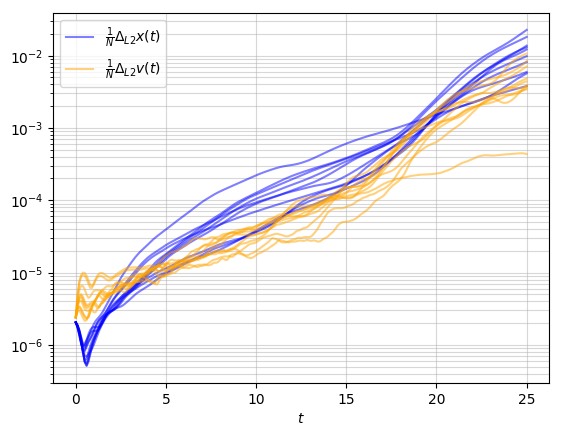

In [78]:
deltax, = PyPlot.plot(t1, Xₑᵣᵣ, color="blue", alpha=0.5)
deltav, = PyPlot.plot(t1, Vₑᵣᵣ, color="orange", alpha=0.5)
PyPlot.xlabel(L"$t$")
PyPlot.yscale("log")
PyPlot.grid("true", which="both", alpha=0.5)
PyPlot.legend((deltax, deltav), (L"$\frac{1}{N} \Delta_{L2} x(t) $", L"$\frac{1}{N} \Delta_{L2} v(t) $"))
#PyPlot.savefig("../Presentations/SPROM Workshop/BoT_DEIM_xv.pdf")

In [16]:
argmax(Xₑᵣᵣ[size(Xₑᵣᵣ)[1],:])

7

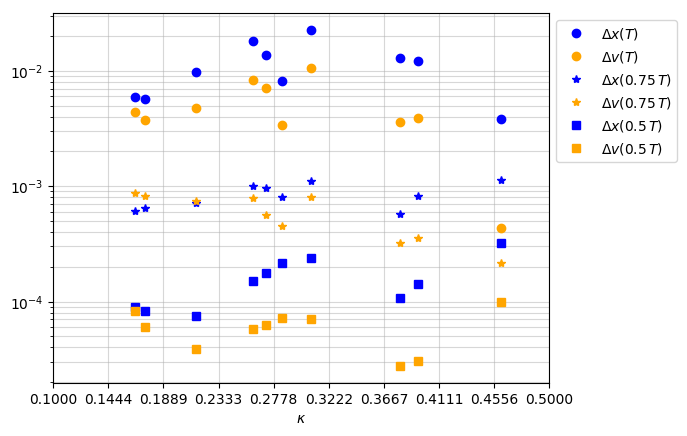

PyObject <matplotlib.legend.Legend object at 0x7f4e119d19e8>

In [17]:
PyPlot.plot(μₜₑₛₜ[:,1], Xₑᵣᵣ[IPₜₑₛₜ.nₛ,:], "o", color="blue")
PyPlot.plot(μₜₑₛₜ[:,1], Vₑᵣᵣ[IPₜₑₛₜ.nₛ,:], "o", color="orange")
PyPlot.plot(μₜₑₛₜ[:,1], Xₑᵣᵣ[3*div(IPₜₑₛₜ.nₛ-1,4),:], "*", color="blue")
PyPlot.plot(μₜₑₛₜ[:,1], Vₑᵣᵣ[3*div(IPₜₑₛₜ.nₛ-1,4),:], "*", color="orange")
PyPlot.plot(μₜₑₛₜ[:,1], Xₑᵣᵣ[div(IPₜₑₛₜ.nₛ-1,2),:], "s", color="blue")
PyPlot.plot(μₜₑₛₜ[:,1], Vₑᵣᵣ[div(IPₜₑₛₜ.nₛ-1,2),:], "s", color="orange")
# PyPlot.plot(μₜₑₛₜ[:,1], Xₑᵣᵣ[1,:], "h", color="blue")
# PyPlot.plot(μₜₑₛₜ[:,1], Vₑᵣᵣ[1,:], "h", color="orange")
PyPlot.xlabel(L"$κ$")
PyPlot.xticks(μₜᵣₐᵢₙ[:,1])
PyPlot.yscale("log")
PyPlot.grid("true", which="both", alpha=0.5)
lgd = PyPlot.legend([L"$\Delta x(T)$", L"$\Delta v(T)$", 
               L"$\Delta x(0.75 \, T)$", L"$\Delta v(0.75 \, T)$", 
               L"$\Delta x(0.5 \, T)$", L"$\Delta v(0.5 \, T)$"],
               loc="top left",
               bbox_to_anchor=(1.0, 1.0))
#PyPlot.savefig("Latex/images/final_errors_xv_frozen_phi.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

In [18]:
norm(Xₑᵣᵣ)/(IPₜₑₛₜ.nₛ*nₜₑₛₜ), norm(Vₑᵣᵣ)/(IPₜₑₛₜ.nₛ*nₜₑₛₜ)

(6.223578182451126e-5, 2.9526836772947795e-5)

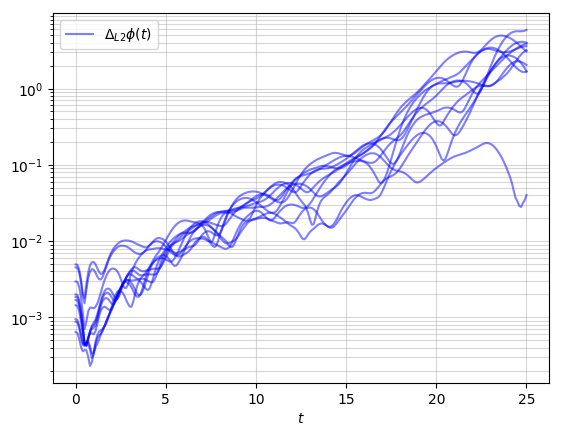

PyObject <matplotlib.legend.Legend object at 0x7f4e11a04198>

In [19]:
Φₑᵣᵣ = zero(t);
for i in eachindex(t)
    Φₑᵣᵣ[i] = norm(Φᵣₘ[:,i] - Φₜₑₛₜ[:,i]) # / norm(Φₜₑₛₜ[:,i])
end

Φₑᵣᵣ = reshape(Φₑᵣᵣ, (IPₜₑₛₜ.nₛ,nₜₑₛₜ));

#plot(t1, Φₑᵣᵣ, yaxis = :log, legend=:bottomright)

PyPlot.plot(t1, Φₑᵣᵣ, color="blue", alpha=0.5)
PyPlot.xlabel(L"$t$")
PyPlot.yscale("log")
PyPlot.grid("true", which="both", alpha=0.5)
PyPlot.legend([L"$\Delta_{L2} \phi(t) $"])
#PyPlot.savefig("../Presentations/SPROM Workshop/noDEIM_phi.pdf")

In [20]:
norm(Φₑᵣᵣ)/(IPₜₑₛₜ.nₛ*nₜₑₛₜ)

0.020421490384632424

In [21]:
K = stiffnessmatrix_PBSpline(S)
Wₜₑₛₜ = zero(t);
Wᵣₘ = zero(t);
Wₑᵣᵣ = zero(t);
for i in eachindex(t)
    Wₜₑₛₜ[i] = 0.5 * dot(Φₜₑₛₜ[:,i], K*Φₜₑₛₜ[:,i])
end
for i in eachindex(t)
    Wᵣₘ[i] = 0.5 * dot(Φᵣₘ[:,i], K*Φᵣₘ[:,i])
    Wₑᵣᵣ[i] = abs(Wₜₑₛₜ[i] - Wᵣₘ[i]) / Wₜₑₛₜ[i]
end
Wᵣₘ = reshape(Wᵣₘ, (IPₜₑₛₜ.nₛ,nₜₑₛₜ))
Wₜₑₛₜ = reshape(Wₜₑₛₜ, (IPₜₑₛₜ.nₛ,nₜₑₛₜ))

for p in 1:nₜₑₛₜ
    Wᵣₘ[:,p] .*= χₜₑₛₜ[p]^2
    Wₜₑₛₜ[:,p] .*= χₜₑₛₜ[p]^2
end

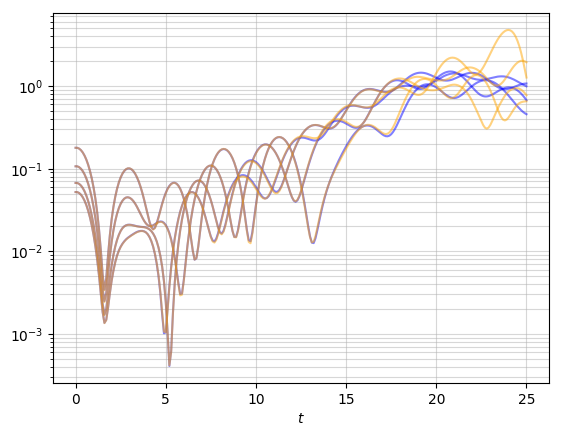

In [22]:
PyPlot.plot(t1, Wₜₑₛₜ[:,1:2:7], color="blue", alpha=0.5)
PyPlot.plot(t1, Wᵣₘ[:,1:2:7], color="orange", alpha=0.5)
PyPlot.xlabel(L"$t$")
PyPlot.yscale("log")
PyPlot.grid("true", which="both", alpha=0.5)
#PyPlot.legend([L"$W_{HFM}$", L"$W_{RM}$"])

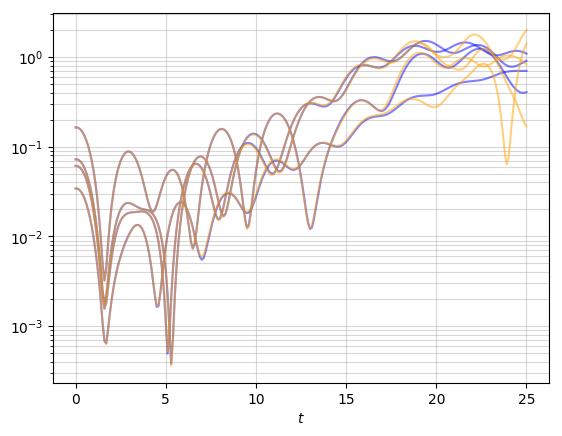

In [23]:
PyPlot.plot(t1, Wₜₑₛₜ[:,2:2:8], color="blue", alpha=0.5)
PyPlot.plot(t1, Wᵣₘ[:,2:2:8], color="orange", alpha=0.5)
PyPlot.xlabel(L"$t$")
PyPlot.yscale("log")
PyPlot.grid("true", which="both", alpha=0.5)
#PyPlot.legend([L"$W_{HFM}$", L"$W_{RM}$"])

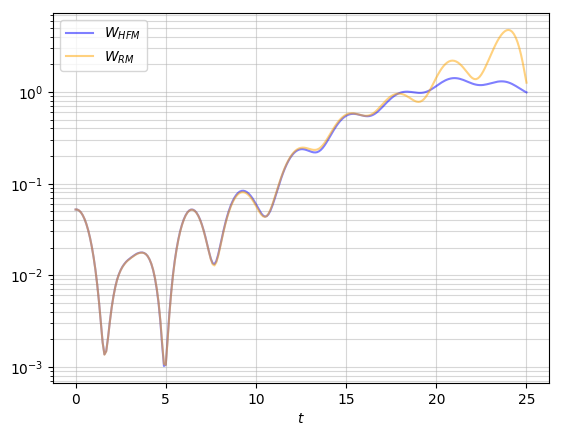

PyObject <matplotlib.legend.Legend object at 0x7f4e09589898>

In [24]:
j = 7
PyPlot.plot(t1, Wₜₑₛₜ[:,j], color="blue", alpha=0.5)
PyPlot.plot(t1, Wᵣₘ[:,j], color="orange", alpha=0.5)
PyPlot.xlabel(L"$t$")
PyPlot.yscale("log")
PyPlot.grid("true", which="both", alpha=0.5)
PyPlot.legend([L"$W_{HFM}$", L"$W_{RM}$"])

In [25]:
norm(Wₑᵣᵣ)/(IPₜₑₛₜ.nₛ*nₜₑₛₜ)

0.005524093307804748

In [26]:
Eₜₑₛₜ = zero(t)
Eᵣₘ = zero(t)
Eₑᵣᵣ = zero(t);
W = Diagonal(ones(IPₜₑₛₜ.Nₚ).*w)

### Self-consistent Phi case

for i in eachindex(t)
    Eₜₑₛₜ[i] = 0.5*dot(Vₜₑₛₜ[:,i],Vₜₑₛₜ[:,i] .* w) + Wₜₑₛₜ[i]
    Eᵣₘ[i] = 0.5*dot(Vᵣₘ[:,i], W * Vᵣₘ[:,i]) + Wᵣₘ[i]
    Eₑᵣᵣ[i] = abs(Eₜₑₛₜ[i] - Eᵣₘ[i]) / Eₜₑₛₜ[i]
end

### Frozen Phi case

# for i in eachindex(t)
#     Eₜₑₛₜ[i] = 0.5*dot(Vₜₑₛₜ[:,i],W * Vₜₑₛₜ[:,i]) - dot(P₀.w, eval_PBSBasis(Φₜₑₛₜ[:,i],S,Xₜₑₛₜ[:,i])) 
#     Eᵣₘ[i] = 0.5*dot(Vᵣₘ[:,i], W * Vᵣₘ[:,i]) - dot(P₀.w, eval_PBSBasis(Φᵣₘ[:,i],S,Xᵣₘ[:,i]))
#     Eₑᵣᵣ[i] = abs(Eₜₑₛₜ[i] - Eᵣₘ[i]) / Eₜₑₛₜ[i]
# end

In [27]:
Eᵣₘ = reshape(Eᵣₘ, (IPₜₑₛₜ.nₛ,nₜₑₛₜ))
Eₜₑₛₜ = reshape(Eₜₑₛₜ, (IPₜₑₛₜ.nₛ,nₜₑₛₜ))
Eₑᵣᵣ = reshape(Eₑᵣᵣ, (IPₜₑₛₜ.nₛ,nₜₑₛₜ));

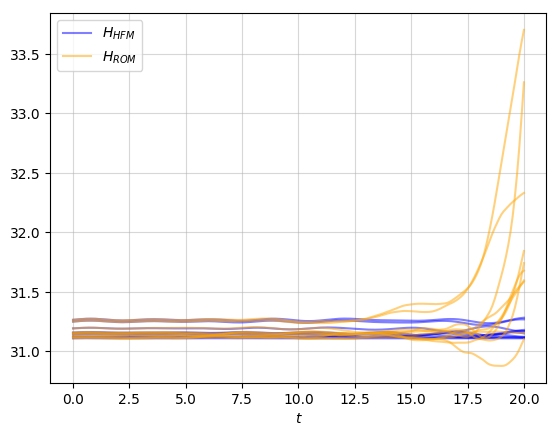

In [80]:
HFM, = PyPlot.plot(t1[1:201], Eₜₑₛₜ[1:201,:], color = "blue", alpha=0.5)
ROM, = PyPlot.plot(t1[1:201], Eᵣₘ[1:201,:], color = "orange", alpha=0.5)
PyPlot.xlabel(L"$t$")
#PyPlot.yscale("log")
PyPlot.grid("true", which="both", alpha=0.5)
PyPlot.legend((HFM, ROM), (L"$H_{HFM}$", L"$H_{ROM}$"))
#PyPlot.savefig("../Presentations/SPROM Workshop/BoT_DEIM_H.pdf")

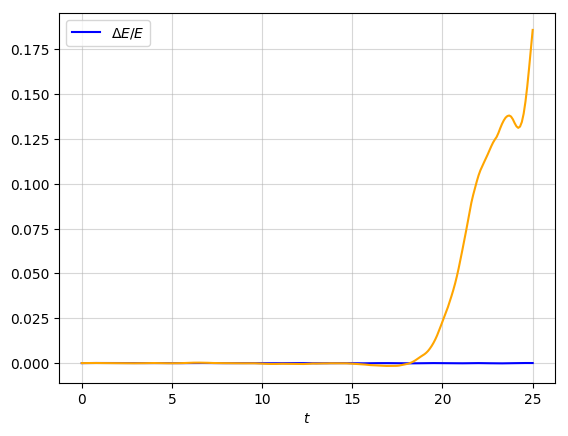

PyObject <matplotlib.legend.Legend object at 0x7f4e095c2748>

In [32]:
j = 8
PyPlot.plot(t1, Eₜₑₛₜ[:,j]./Eₜₑₛₜ[1,j] .- 1.0, color = "blue")
PyPlot.plot(t1, Eᵣₘ[:,j]./Eᵣₘ[1,j] .- 1.0, color = "orange")
PyPlot.xlabel(L"$t$")
#PyPlot.yscale("log")
PyPlot.grid("true", which="both", alpha=0.5)
PyPlot.legend([L"$\Delta E/E$"])

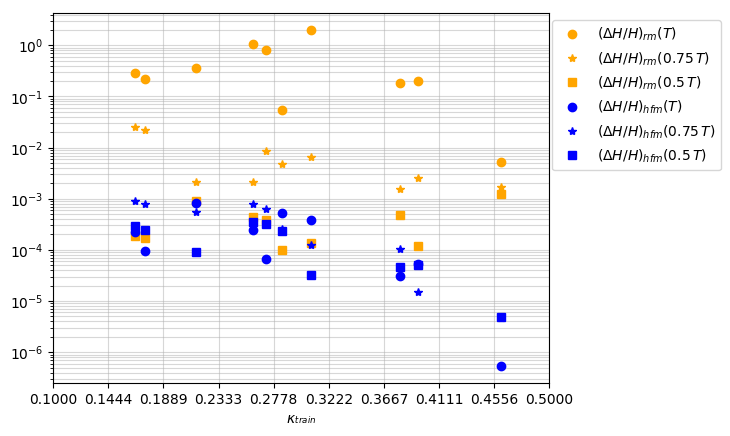

PyObject <matplotlib.legend.Legend object at 0x7f4e09584ac8>

In [33]:
PyPlot.plot(μₜₑₛₜ[:,1], abs.(Eᵣₘ[IPₜₑₛₜ.nₛ,:] ./ Eᵣₘ[1,:] .- 1), "o", color="orange")
PyPlot.plot(μₜₑₛₜ[:,1], abs.(Eᵣₘ[3*div(IPₜₑₛₜ.nₛ-1,4),:] ./ Eᵣₘ[1,:] .- 1), "*", color="orange")
PyPlot.plot(μₜₑₛₜ[:,1], abs.(Eᵣₘ[div(IPₜₑₛₜ.nₛ-1,2),:] ./ Eᵣₘ[1,:] .- 1), "s", color="orange")
PyPlot.plot(μₜₑₛₜ[:,1], abs.(Eₜₑₛₜ[IPₜₑₛₜ.nₛ,:] ./ Eₜₑₛₜ[1,:] .- 1), "o", color="blue")
PyPlot.plot(μₜₑₛₜ[:,1], abs.(Eₜₑₛₜ[3*div(IPₜₑₛₜ.nₛ-1,4),:] ./ Eₜₑₛₜ[1,:] .- 1), "*", color="blue")
PyPlot.plot(μₜₑₛₜ[:,1], abs.(Eₜₑₛₜ[div(IPₜₑₛₜ.nₛ-1,2),:] ./ Eₜₑₛₜ[1,:] .- 1), "s", color="blue")
PyPlot.xlabel(L"$κₜᵣₐᵢₙ$")
PyPlot.xticks(μₜᵣₐᵢₙ[:,1])
PyPlot.yscale("log")
PyPlot.grid("true", which="both", alpha=0.5)
lgd = PyPlot.legend([L"$(\Delta H/H)_{rm}(T)$",
               L"$(\Delta H/H)_{rm}(0.75 \, T)$",
               L"$(\Delta H/H)_{rm}(0.5 \, T)$",
               L"$(\Delta H/H)_{hfm}(T)$",
               L"$(\Delta H/H)_{hfm}(0.75 \, T)$",
               L"$(\Delta H/H)_{hfm}(0.5 \, T)$"],
               loc="top left",
               bbox_to_anchor=(1.36, 1.0))
#PyPlot.savefig("Latex/images/final_errors_H_frozen_phi.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

In [34]:
function find_maxima(w, n)
    maxima = []
    for i in (1+n):(length(w)-n)
        if issorted(w[i-n:i], lt=isless) && issorted(w[i:i+n], lt=isless, rev = true)
            append!(maxima, i)
        end
        end
    return maxima
end

function get_regression_αβ(t, W, n)
    nₚ = size(W, 2)
    α = zeros(nₚ)
    β = zeros(nₚ)
    for i in 1:nₚ
        m = find_maxima(W[:,i], n)
        #!! Bump on Tail
        if length(m) < 4
            m = m[1:end]
        else
            m = m[1:4]
        end
        β[i] = cov(t[m], log.(W[m,i]), corrected=false) / var(t[m], corrected=false) 
        α[i] = mean(log.(W[m,i])) - β[i]*mean(t[m])
    end
    return α, β
end

αᵣₘ, βᵣₘ = get_regression_αβ(t1, Wᵣₘ, 5);
αₜₑₛₜ, βₜₑₛₜ = get_regression_αβ(t1, Wₜₑₛₜ, 5);

In [35]:
(βₜₑₛₜ .- βᵣₘ) #./βₜₑₛₜ

10-element Array{Float64,1}:
 -0.00034090677488779475
  0.00025345917543195817
  0.00017938200764633372
  0.0005092142009162082 
  0.0001220033832342593 
  0.002228572699827569  
 -0.0036729454618471546 
 -0.0046809472217756165 
 -0.0029891300097091567 
 -0.002000211044098591  

In [36]:
mean(abs.(βₜₑₛₜ .- βᵣₘ))

0.0016976771979374642

In [37]:
maximum(abs.((βₜₑₛₜ .- βᵣₘ)./βₜₑₛₜ))

0.15379323155766994

In [81]:
argmax(abs.((βₜₑₛₜ .- βᵣₘ)))

8

In [82]:
argmin(abs.((βₜₑₛₜ .- βᵣₘ)))

5

In [83]:
βₜₑₛₜ

10-element Array{Float64,1}:
 0.12878638342500975 
 0.14632976073569007 
 0.24619447753857468 
 0.25202429124861464 
 0.26425283425581625 
 0.2873203727944792  
 0.27891268646988765 
 0.20074337287118843 
 0.17575474783787828 
 0.013005845730919209

In [84]:
βᵣₘ

10-element Array{Float64,1}:
 0.12912729019989755
 0.1460763015602581 
 0.24601509553092835
 0.25151507704769843
 0.264130830872582  
 0.2850918000946516 
 0.2825856319317348 
 0.20542432009296405
 0.17874387784758744
 0.0150060567750178 

In [85]:
Wₗᵢₙ_ᵣₘ = zero(Wᵣₘ)
Wₗᵢₙ_ₜₑₛₜ = zero(Wₜₑₛₜ)
for i in 1:size(Wᵣₘ,2)
    Wₗᵢₙ_ₜₑₛₜ[:,i] .= exp.(αₜₑₛₜ[i] .+ βₜₑₛₜ[i] .* t1)
    Wₗᵢₙ_ᵣₘ[:,i] .= exp.(αᵣₘ[i] .+ βᵣₘ[i] .* t1)
end

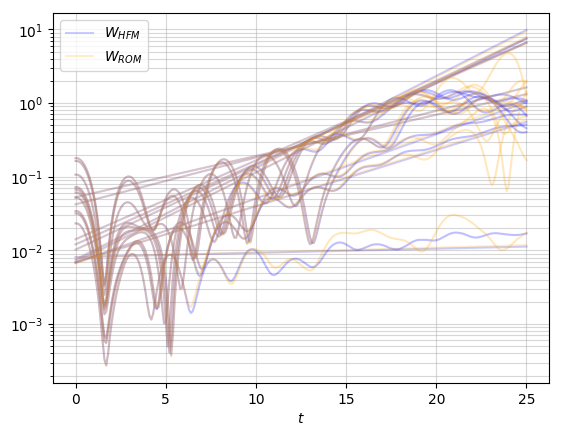

In [94]:
WHFM, = PyPlot.plot(t1, Wₜₑₛₜ, alpha = 0.25, color = "blue")
LHFM, = PyPlot.plot(t1, Wₗᵢₙ_ₜₑₛₜ, alpha = 0.2, color = "blue")
WROM, = PyPlot.plot(t1, Wᵣₘ, alpha = 0.25, color = "orange")
LROM, = PyPlot.plot(t1, Wₗᵢₙ_ᵣₘ, alpha = 0.2, color = "orange")

#PyPlot.plot(t1[m], Wᵣₘ[7,5], "o", color = "orange")
PyPlot.xlabel(L"$t$")
PyPlot.yscale("log")
PyPlot.grid("true", which="both", alpha=0.5)
PyPlot.legend((LHFM, LROM), (L"$W_{HFM}$", L"$W_{ROM}$"))
#PyPlot.savefig("../Presentations/SPROM Workshop/BoT_DEIM_W.pdf")

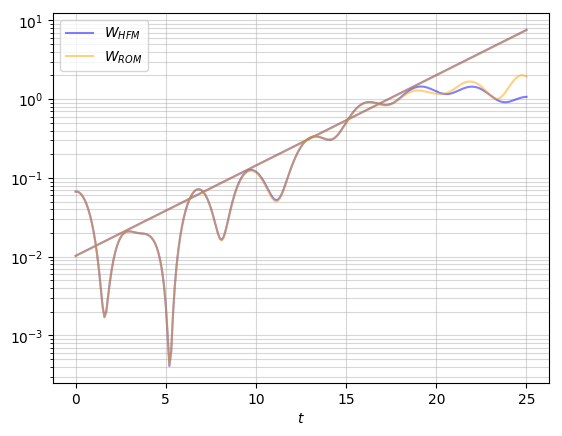

PyObject <matplotlib.legend.Legend object at 0x7f4e0549fb70>

In [95]:
j = argmin(abs.((βₜₑₛₜ .- βᵣₘ)))

WHFM, = PyPlot.plot(t1, Wₜₑₛₜ[:,j], alpha = 0.5, color = "blue")
LHFM, = PyPlot.plot(t1, Wₗᵢₙ_ₜₑₛₜ[:,j], alpha = 0.5, color = "blue")
WROM, = PyPlot.plot(t1, Wᵣₘ[:,j], alpha = 0.5, color = "orange")
LROM, = PyPlot.plot(t1, Wₗᵢₙ_ᵣₘ[:,j], alpha = 0.5, color = "orange")

# PyPlot.plot(t1[m], Wᵣₘ[m,5], "o", color = "orange")
PyPlot.xlabel(L"$t$")
PyPlot.yscale("log")
PyPlot.grid("true", which="both", alpha=0.5)
PyPlot.legend((LHFM, LROM), (L"$W_{HFM}$", L"$W_{ROM}$"))
#PyPlot.savefig("../Presentations/SPROM Workshop/BoT_DEIM_W_detail.pdf")

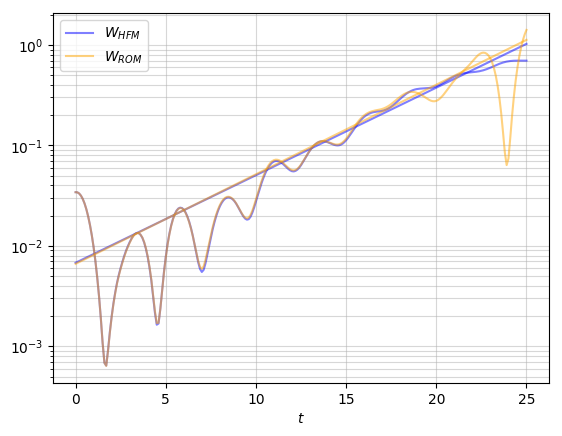

In [123]:
j = argmax(abs.((βₜₑₛₜ .- βᵣₘ)))

WHFM, = PyPlot.plot(t1, Wₜₑₛₜ[:,j], alpha = 0.5, color = "blue")
LHFM, = PyPlot.plot(t1, Wₗᵢₙ_ₜₑₛₜ[:,j], alpha = 0.5, color = "blue")
WROM, = PyPlot.plot(t1, Wᵣₘ[:,j], alpha = 0.5, color = "orange")
LROM, = PyPlot.plot(t1, Wₗᵢₙ_ᵣₘ[:,j], alpha = 0.5, color = "orange")

# PyPlot.plot(t1[m], Wᵣₘ[m,5], "o", color = "orange")
PyPlot.xlabel(L"$t$")
PyPlot.yscale("log")
PyPlot.grid("true", which="both", alpha=0.5)
PyPlot.legend((LHFM, LROM), (L"$W_{HFM}$", L"$W_{ROM}$"))
PyPlot.savefig("../Presentations/SPROM Workshop/BoT_DEIM_W_detail.pdf")

In [124]:
μₜₑₛₜ[j,:]'

1×5 Adjoint{Float64,Array{Float64,1}}:
 0.380056  0.03  0.1  4.5  0.5

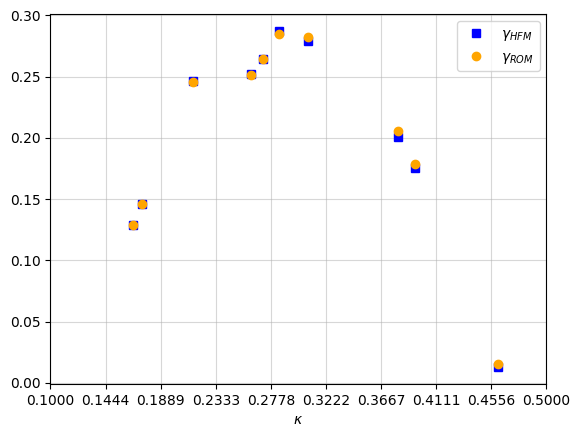

In [99]:
PyPlot.plot(μₜₑₛₜ[:,1], βₜₑₛₜ, "s", color="blue")
PyPlot.plot(μₜₑₛₜ[:,1], βᵣₘ, "o", color="orange")
PyPlot.xlabel(L"$κ$")
PyPlot.xticks(μₜᵣₐᵢₙ[:,1])
#PyPlot.yscale("log")
PyPlot.grid("true", which="both", alpha=0.5)
lgd = PyPlot.legend([L"$γ_{HFM}$", L"$γ_{ROM}$"])
#PyPlot.savefig("../Presentations/SPROM Workshop/BoT_DEIM_decayrate.pdf")

# Pictures

In [165]:
resolution = Int(round(sqrt(2*IPₜₑₛₜ.Nₚ)));
L = S.L
Nₚ = IPₜₑₛₜ.Nₚ
nₜ = IPₜₑₛₜ.nₜ;
vmax = 10.0
vmin = -5.0;
j = argmax(βₜₑₛₜ)

6

In [166]:
μₜₑₛₜ[j,:]'

1×5 Adjoint{Float64,Array{Float64,1}}:
 0.284359  0.03  0.1  4.5  0.5

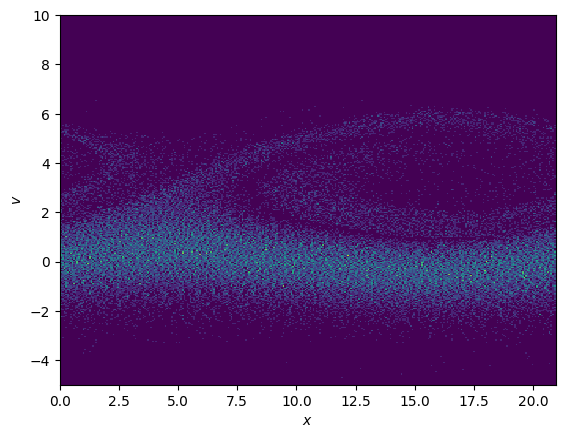

In [167]:
for i in 0:25
    plot_particles(collect(range(0,stop=L,length=resolution)),
                    collect(range(vmin,stop=vmax,length=resolution)), 
                    Particles(Xₜₑₛₜ[:, 1 + (j-1)*Int(IPₜₑₛₜ.nₛ)+Int(i*div(IPₜₑₛₜ.nₛ-1,25))], 
                                Vₜₑₛₜ[:, 1 + (j-1)*Int(IPₜₑₛₜ.nₛ)+Int(i*div(IPₜₑₛₜ.nₛ-1,25))], w), L)
    PyPlot.savefig("../Presentations/SPROM Workshop/BoT_DEIM_f_full_" * string(i) * ".png")
end

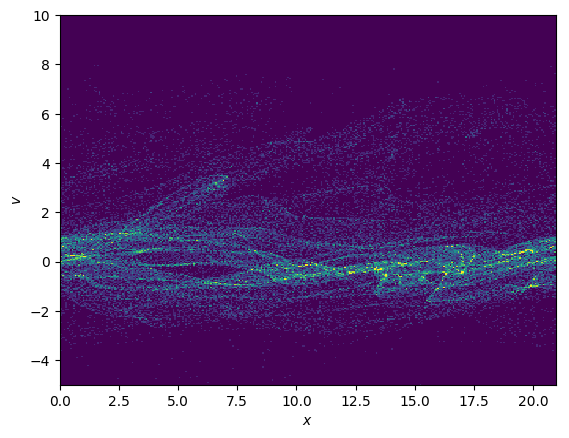

In [168]:
for i in 0:25
    plot_particles(collect(range(0,stop=L,length=resolution)),
                    collect(range(vmin,stop=vmax,length=resolution)), 
                    Particles(Xᵣₘ[:, 1 + (j-1)*Int(IPₜₑₛₜ.nₛ)+Int(i*div(IPₜₑₛₜ.nₛ-1,25))], 
                                Vᵣₘ[:, 1 + (j-1)*Int(IPₜₑₛₜ.nₛ)+Int(i*div(IPₜₑₛₜ.nₛ-1,25))], w), L)
    PyPlot.savefig("../Presentations/SPROM Workshop/BoT_DEIM_f_reduc_" * string(i) * ".png")
end